# IMPORTS

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ast
from textblob import TextBlob  
from collections import Counter


# SETTINGS

In [5]:
SETTINGS = {
    "DATA_RUTE": r"data/",
    "ORIGINAL_DATA_RUTE": r"data/original_data/",
    "DATA_VERSION": 3,
    
    "MODEL_SETTINGS":{
        "LAYER_SIZE": 128,
        "GENRE_THRESHOLD": 0.5,
        "TEST_SET": 0,
        "TEST_PROPORTION": 0.2,
        "SEED": 42,
    },
}

# DATA LOADING

In [6]:
if SETTINGS["DATA_VERSION"] == 0:
    column_names = [
        "wikipedia_movie_ID", 
        "freebase_movie_ID", 
        "name", 
        "release_date", 
        "box_office_revenue", 
        "runtime", 
        "languages", 
        "countries", 
        "genres"
    ]
    MOVIES = pd.read_csv(f'{SETTINGS["ORIGINAL_DATA_RUTE"]}movie.metadata.tsv', sep='\t', header=None, encoding='utf-8', na_values=['NA', ''], names=column_names)
    
elif SETTINGS["DATA_VERSION"] == 1: 
    MOVIES = pd.read_csv(f'{SETTINGS["DATA_RUTE"]}TMDB_movie_dataset_v11.csv')
    MOVIES = MOVIES.drop(columns=["homepage", "poster_path", "backdrop_path"])
    
elif SETTINGS["DATA_VERSION"] == 2: 
    column_names = [
        "name", 
        "rating", 
        "genre", 
        "release_year", 
        "status", 
        "score", 
        "votes", 
        "director", 
        "writer", 
        "star",
        "country", 
        "budget", 
        "box_office_revenue", 
        "company",
        "runtime", 
    ]
    MOVIES = pd.read_csv(f'{SETTINGS["DATA_RUTE"]}movies.csv', names=column_names)
    MOVIES = MOVIES.drop(columns=["director", "writer", "star"])
    MOVIES = MOVIES.drop(MOVIES.index[0])
    
elif SETTINGS["DATA_VERSION"] == 3:
    column_names = [
        "wikipedia_movie_ID", 
        "freebase_movie_ID", 
        "name", 
        "release_date", 
        "revenue", 
        "runtime", 
        "languages", 
        "countries", 
        "genres"
    ]
    MOVIES_ORIGINAL = pd.read_csv(f'{SETTINGS["ORIGINAL_DATA_RUTE"]}movie.metadata.tsv', sep='\t', header=None, encoding='utf-8', na_values=['NA', ''], names=column_names)
    
    column_names = [
        'id_new', 
        'title', 
        'vote_average', 
        'vote_count', 
        'status_new', 
        'release_date_new',
        'revenue_new', 
        'runtime_new', 
        'adult', 
        'backdrop_path', 
        'budget', 
        'homepage',
        'imdb_id', 
        'original_language', 
        'original_title', 
        'overview',
        'popularity', 
        'poster_path', 
        'tagline', 
        'genres_new',
        'production_companies', 
        'production_countries', 
        'spoken_languages',
        'keywords'
    ]
    MOVIES_NEW = pd.read_csv(f'{SETTINGS["DATA_RUTE"]}TMDB_movie_dataset_v11.csv', sep=',', header=None, encoding='utf-8', na_values=['NA', ''], names=column_names)
    
    
        
    MOVIES_ORIGINAL['name'] = MOVIES_ORIGINAL['name'].str.strip().str.lower()
    MOVIES_NEW['title'] = MOVIES_NEW['title'].str.strip().str.lower()
    
        
    MOVIES_ORIGINAL["release_year"] = pd.to_datetime(MOVIES_ORIGINAL['release_date'], errors='coerce').dt.year
    MOVIES_ORIGINAL["release_year"] = MOVIES_ORIGINAL["release_year"].fillna(0).astype(int)
    
    MOVIES_NEW["release_year"] = pd.to_datetime(MOVIES_NEW['release_date_new'], errors='coerce').dt.year
    MOVIES_NEW["release_year"] = MOVIES_NEW["release_year"].fillna(0).astype(int)
    
    MOVIES = pd.merge(MOVIES_ORIGINAL, MOVIES_NEW, left_on=['name', "release_year"], right_on=['title', "release_year"], how='left')
    MOVIES = MOVIES.drop(columns=[
        "id_new", "title", "status_new", "release_date_new", "revenue_new", "runtime_new", "imdb_id",
        "original_language", "original_title", "overview", "tagline", "genres_new", 'production_companies', 
        'production_countries', 'spoken_languages', 'keywords', "homepage", "poster_path", "backdrop_path"
    ])    
    
MOVIES.head()

C:\Users\fredr\AppData\Local\Temp\ipykernel_28204\531925455.py:81: DtypeWarning: Columns (0,2,3,6,7,8,10,16) have mixed types. Specify dtype option on import or set low_memory=False.
  MOVIES_NEW = pd.read_csv(f'{SETTINGS["DATA_RUTE"]}TMDB_movie_dataset_v11.csv', sep=',', header=None, encoding='utf-8', na_values=['NA', ''], names=column_names)
C:\Users\fredr\AppData\Local\Temp\ipykernel_28204\531925455.py:92: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  MOVIES_NEW["release_year"] = pd.to_datetime(MOVIES_NEW['release_date_new'], errors='coerce').dt.year


,wikipedia_movie_ID,freebase_movie_ID,name,release_date,revenue,runtime,languages,countries,genres,release_year,vote_average,vote_count,adult,budget,popularity
0,975900,/m/03vyhn,ghosts of mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001,5.127,977,False,28000000,14.189
1,3196793,/m/08yl5d,getting away with murder: the jonbenét ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",2000,0.0,0,False,0,0.6
2,28463795,/m/0crgdbh,brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",0,NaN,NaN,NaN,NaN,NaN
3,9363483,/m/0285_cd,white of the eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",0,NaN,NaN,NaN,NaN,NaN
4,261236,/m/01mrr1,a woman in flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",0,NaN,NaN,NaN,NaN,NaN


In [7]:
column_names = [
    "Wikipedia movie ID",
    "Freebase movie ID",
    "Movie release date",
    "Character name",
    "Actor date of birth",
    "Actor gender",
    "Actor height (in meters)",
    "Actor ethnicity (Freebase ID)",
    "Actor name",
    "Actor age at movie release",
    "Freebase character/actor map ID",
    "Freebase character ID",
    "Freebase actor ID"
]
CHARACTER = pd.read_csv(f'{SETTINGS["ORIGINAL_DATA_RUTE"]}character.metadata.tsv', sep='\t', header=None, encoding='utf-8', na_values=['NA', ''], names=column_names)

CHARACTER.head()

,Wikipedia movie ID,Freebase movie ID,Movie release date,Character name,Actor date of birth,Actor gender,Actor height (in meters),Actor ethnicity (Freebase ID),Actor name,Actor age at movie release,Freebase character/actor map ID,Freebase character ID,Freebase actor ID
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


In [8]:
column_names = [
    "wikipedia_movie_ID",
    "plot"
]

PLOTS = pd.read_csv(f'{SETTINGS["ORIGINAL_DATA_RUTE"]}plot_summaries.txt', sep='\t', header=None, encoding='utf-8', names=column_names)
MOVIES = pd.merge(MOVIES, PLOTS, on="wikipedia_movie_ID", how="inner")

MOVIES.head()

,wikipedia_movie_ID,freebase_movie_ID,name,release_date,revenue,runtime,languages,countries,genres,release_year,vote_average,vote_count,adult,budget,popularity,plot
0,975900,/m/03vyhn,ghosts of mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001,5.127,977,False,28000000,14.189,"Set in the second half of the 22nd century, th..."
1,9363483,/m/0285_cd,white of the eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",0,NaN,NaN,NaN,NaN,NaN,A series of murders of rich young women throug...
2,261236,/m/01mrr1,a woman in flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",0,NaN,NaN,NaN,NaN,NaN,"Eva, an upper class housewife, becomes frustra..."
3,18998739,/m/04jcqvw,the sorcerer's apprentice,2002,NaN,86.0,"{""/m/02h40lc"": ""English Language""}","{""/m/0hzlz"": ""South Africa""}","{""/m/0hqxf"": ""Family Film"", ""/m/01hmnh"": ""Fant...",0,NaN,NaN,NaN,NaN,NaN,"Every hundred years, the evil Morgana returns..."
4,6631279,/m/0gffwj,little city,1997-04-04,NaN,93.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/0hj3n0w"": ...",1997,3.833,6,False,0,1.556,"Adam, a San Francisco-based artist who works a..."


In [9]:
MOVIES[MOVIES["name"] == "100 days"]

,wikipedia_movie_ID,freebase_movie_ID,name,release_date,revenue,runtime,languages,countries,genres,release_year,vote_average,vote_count,adult,budget,popularity,plot
43140,8422241,/m/0272wbj,100 days,1991,NaN,161.0,"{""/m/03k50"": ""Hindi Language""}","{""/m/03rk0"": ""India""}","{""/m/03npn"": ""Horror"", ""/m/0c3351"": ""Suspense""...",0,0.0,0,False,0,0.6,Inspired by the Italian Giallo genre of films....
43141,8422241,/m/0272wbj,100 days,1991,NaN,161.0,"{""/m/03k50"": ""Hindi Language""}","{""/m/03rk0"": ""India""}","{""/m/03npn"": ""Horror"", ""/m/0c3351"": ""Suspense""...",0,0.0,0,False,0,0.0,Inspired by the Italian Giallo genre of films....


In [10]:
MOVIES.columns

Index(['wikipedia_movie_ID', 'freebase_movie_ID', 'name', 'release_date',
       'revenue', 'runtime', 'languages', 'countries', 'genres',
       'release_year', 'vote_average', 'vote_count', 'adult', 'budget',
       'popularity', 'plot'],
      dtype='object')

In [11]:
print(len(MOVIES_ORIGINAL["name"].unique()))
print(len(MOVIES_NEW["title"].unique()))
print(len(MOVIES["name"].unique()))
print(len(MOVIES))

75378
958661
39879
45579


In [12]:
print(len(MOVIES_ORIGINAL["name"].unique()))
print(len(MOVIES_NEW["title"].unique()))
print(len(MOVIES["name"].unique()))
print(len(MOVIES))

75378
958661
39879
45579


# DATA WRANGLING

- NANs
- Non sense values
- Gather sub-genre into general genre
- 
  ...

### Release date to year

In [13]:
FIRST_MOVIE_YEAR = 1888
ACTUAL_YEAR = 2024

if "release_date" in MOVIES.columns:
    MOVIES["release_year"] = pd.to_datetime(MOVIES['release_date'], errors='coerce').dt.year
    
MOVIES["release_year"] = MOVIES["release_year"].fillna(0).astype(int)
MOVIES = MOVIES[(MOVIES["release_year"] >= FIRST_MOVIE_YEAR) & (MOVIES["release_year"] <= ACTUAL_YEAR) & (MOVIES["release_year"] != 0)]

print(f'Fist year: {MOVIES["release_year"].min()}, Last year: {MOVIES["release_year"].max()}')
MOVIES["release_year"]

Fist year: 1894, Last year: 2014


0        2001
4        1997
5        1989
8        1964
11       2007
         ... 
45573    2010
45574    1941
45575    2011
45576    2011
45577    1992
Name: release_year, Length: 23330, dtype: int32

### Runtime

In [14]:
MOVIES["runtime"] = MOVIES["runtime"].fillna(0).astype(float)
#MOVIES = MOVIES[(MOVIES["runtime"] >= 40) & (MOVIES["runtime"] <= 200)]

MOVIES["runtime"]

0         98.0
4         93.0
5        137.0
8        139.0
11         0.0
         ...  
45573      0.0
45574     82.0
45575    120.0
45576     96.0
45577    150.0
Name: runtime, Length: 23330, dtype: float64

### Gather sub-genre into general genre

In [15]:
NEW_GENRE = pd.read_csv(f"categories.csv")
NEW_GENRE["subgenres"] = NEW_GENRE["subgenres"].apply(lambda x: ast.literal_eval(x))

NEW_GENRE.head()

,categories,subgenres
0,Action/Adventure,"[Action, Adventure, Action/Adventure, Martial ..."
1,Adaptation,"[Film adaptation, Remake, Live action, Reboot]"
2,Adult,"[Sex comedy, Erotica, Erotic thriller, Pornogr..."
3,Animation,"[Animation, Anime, Computer Animation, Clay an..."
4,Asian Movies,"[Bollywood, Filipino Movies, Chinese Movies, J..."


In [16]:
def get_hot_genre(genre):
    new_genre = []
    genre_hot = []
    
    movie_genre = set(genre)
    
    for _, row in NEW_GENRE.iterrows():
        sub_genres = set(row["subgenres"])
        if bool(movie_genre & sub_genres):
            new_genre.append(row["categories"])
            genre_hot.append(1)
        else: genre_hot.append(0)
    
    return new_genre, genre_hot


In [17]:
MOVIES["original_genres"] = MOVIES["genres"].apply(lambda x: ast.literal_eval(x).values())
MOVIES[["new_genres", "genre_hot"]] = MOVIES["original_genres"].apply(lambda x: pd.Series(get_hot_genre(x)))

In [18]:
MOVIES.head()

,wikipedia_movie_ID,freebase_movie_ID,name,release_date,revenue,runtime,languages,countries,genres,release_year,vote_average,vote_count,adult,budget,popularity,plot,original_genres,new_genres,genre_hot
0,975900,/m/03vyhn,ghosts of mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001,5.127,977,False,28000000,14.189,"Set in the second half of the 22nd century, th...","(Thriller, Science Fiction, Horror, Adventure,...","[Action/Adventure, Horror, Science Fiction, Su...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,6631279,/m/0gffwj,little city,1997-04-04,NaN,93.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/0hj3n0w"": ...",1997,3.833,6,False,0,1.556,"Adam, a San Francisco-based artist who works a...","(Romantic comedy, Ensemble Film, Comedy-drama,...","[Comedy, Drama, Romance, Other]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, ..."
5,171005,/m/016ywb,henry v,1989-11-08,10161099.0,137.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/04xvh5"": ""Costume drama"", ""/m/082gq"": ""Wa...",1989,7.214,330,False,9000000,13.76,{{Plot|dateAct 1Act 2Act 3Act 4Act 5 Finally n...,"(Costume drama, War film, Epic, Period piece, ...","[Adaptation, Drama, Historical, War/combat]","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, ..."
8,77856,/m/0kcn7,mary poppins,1964-08-27,102272727.0,139.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3myq"": ""Children's/Family"", ""/m/04t36""...",1964,7.569,4350,False,6000000,27.399,The film opens with Mary Poppins perched in a...,"(Children's/Family, Musical, Fantasy, Comedy, ...","[Children's/Family, Comedy, Drama, Fantasy, Mu...","[0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, ..."
11,20604092,/m/0523t_1,anbu thozhi,2007-08-17,NaN,0.0,"{""/m/07c9s"": ""Tamil Language""}","{""/m/03rk0"": ""India""}","{""/m/02l7c8"": ""Romance Film""}",2007,NaN,NaN,NaN,NaN,NaN,The film opens with a simpleton from a small v...,(Romance Film),[Romance],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [19]:
print(len(MOVIES_ORIGINAL["name"].unique()))
print(len(MOVIES_NEW["title"].unique()))
print(len(MOVIES["name"].unique()))
print(len(MOVIES))

75378
958661
22025
23330


# DATA EXPANSION
### Get the "theme" features for each movie

In [23]:
from theme_encoding import theme_encoding

# This is for demonstration purposes, but later on list of words will be in dataframes and not as individual lists like this
death_synonyms = [ "killed", "murdered", "assassinated", "slain", "shot", "stabbed", "executed", "died", "perished", "succumbed", "bled", "decapitated", "strangled", "blown", "electrocuted", "drowned", "burned", "poisoned", "crushed", "impaled", "asphyxiated", "bludgeoned", "suffocated", "choked", "eviscerated", "slaughtered", "disintegrated", "torn", "gutted", "hanged", "gassed", "slashed", "ripped", "cut", "disemboweled", "blasted", "tortured", "beheaded", "smashed", "mauled", "knifed", "eaten", "struck", "dismembered", "skinned", "hacked", "pummeled", "pierced", "overpowered", "collapsed", "punched", "squashed", "sliced", "flayed", "stomped", "shattered", "flattened", "scalded", "severed", "hit", "pinned", "decayed", "blasted", "bludgeoned", "throttled", "attacked", "electrocuted", "incinerated" ]

MOVIES["death_theme"] = theme_encoding(MOVIES["plot"], death_synonyms)

### Sentiment analysis of the plot

In [ ]:
MOVIES['sentiment'] = MOVIES['plot'].apply(lambda x: TextBlob(str(x)).sentiment.polarity if pd.notnull(x) else None)

MOVIES['sentiment'].head()

0   -0.085095
1    0.035867
2    0.133259
3    0.040568
4    0.165202
Name: sentiment, dtype: float64

# Data analysis

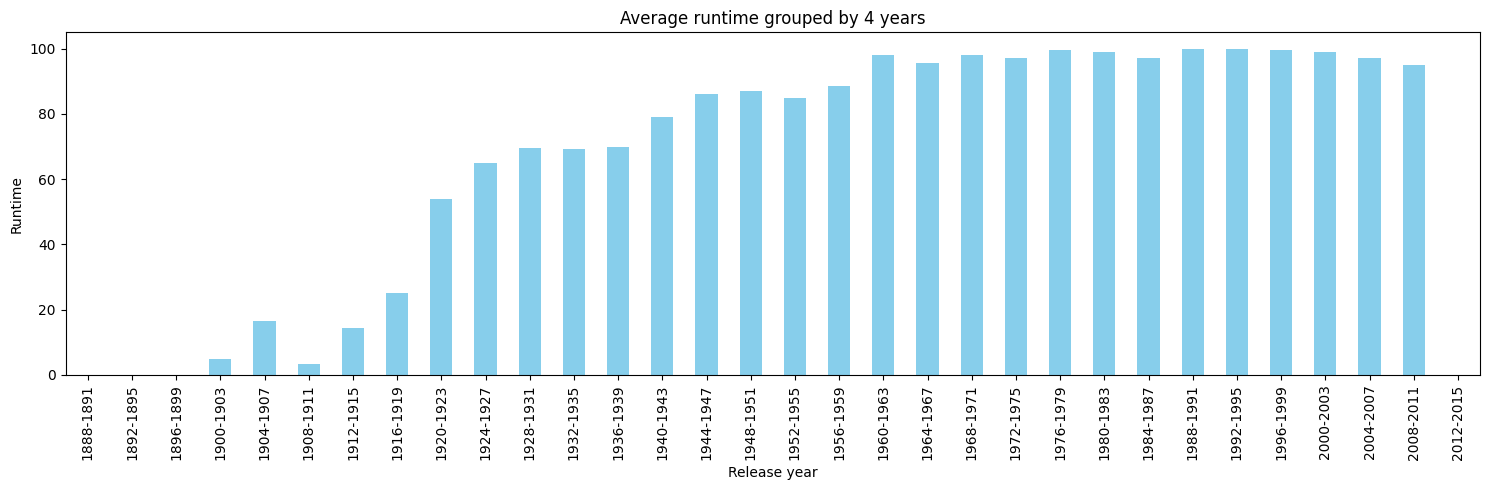

In [ ]:
movies_year_runtime = MOVIES.groupby("release_year")["runtime"].median()

bin_size = 4
binned_runtimes = {}

for i in range(FIRST_MOVIE_YEAR, int(movies_year_runtime.index.max()), bin_size):
    bin_start, bin_end = i, i + bin_size - 1
    
    # Calculate the mean runtime within the current year range (bin)
    total_in_bin = movies_year_runtime[
        (movies_year_runtime.index >= bin_start) & 
        (movies_year_runtime.index <= bin_end)
    ].median()
    
    # Store result in dictionary with bin label as key
    binned_runtimes[f'{bin_start}-{bin_end}'] = total_in_bin

binned_token_counts = pd.Series(binned_runtimes)

# Plot
plt.figure(figsize=(15, 5))
binned_token_counts.plot(kind='bar', color='skyblue')

plt.xlabel('Release year')
plt.ylabel('Runtime')
plt.title(f'Average runtime grouped by {bin_size} years')

plt.tight_layout()
plt.show()

### Genre runtime analysis

39


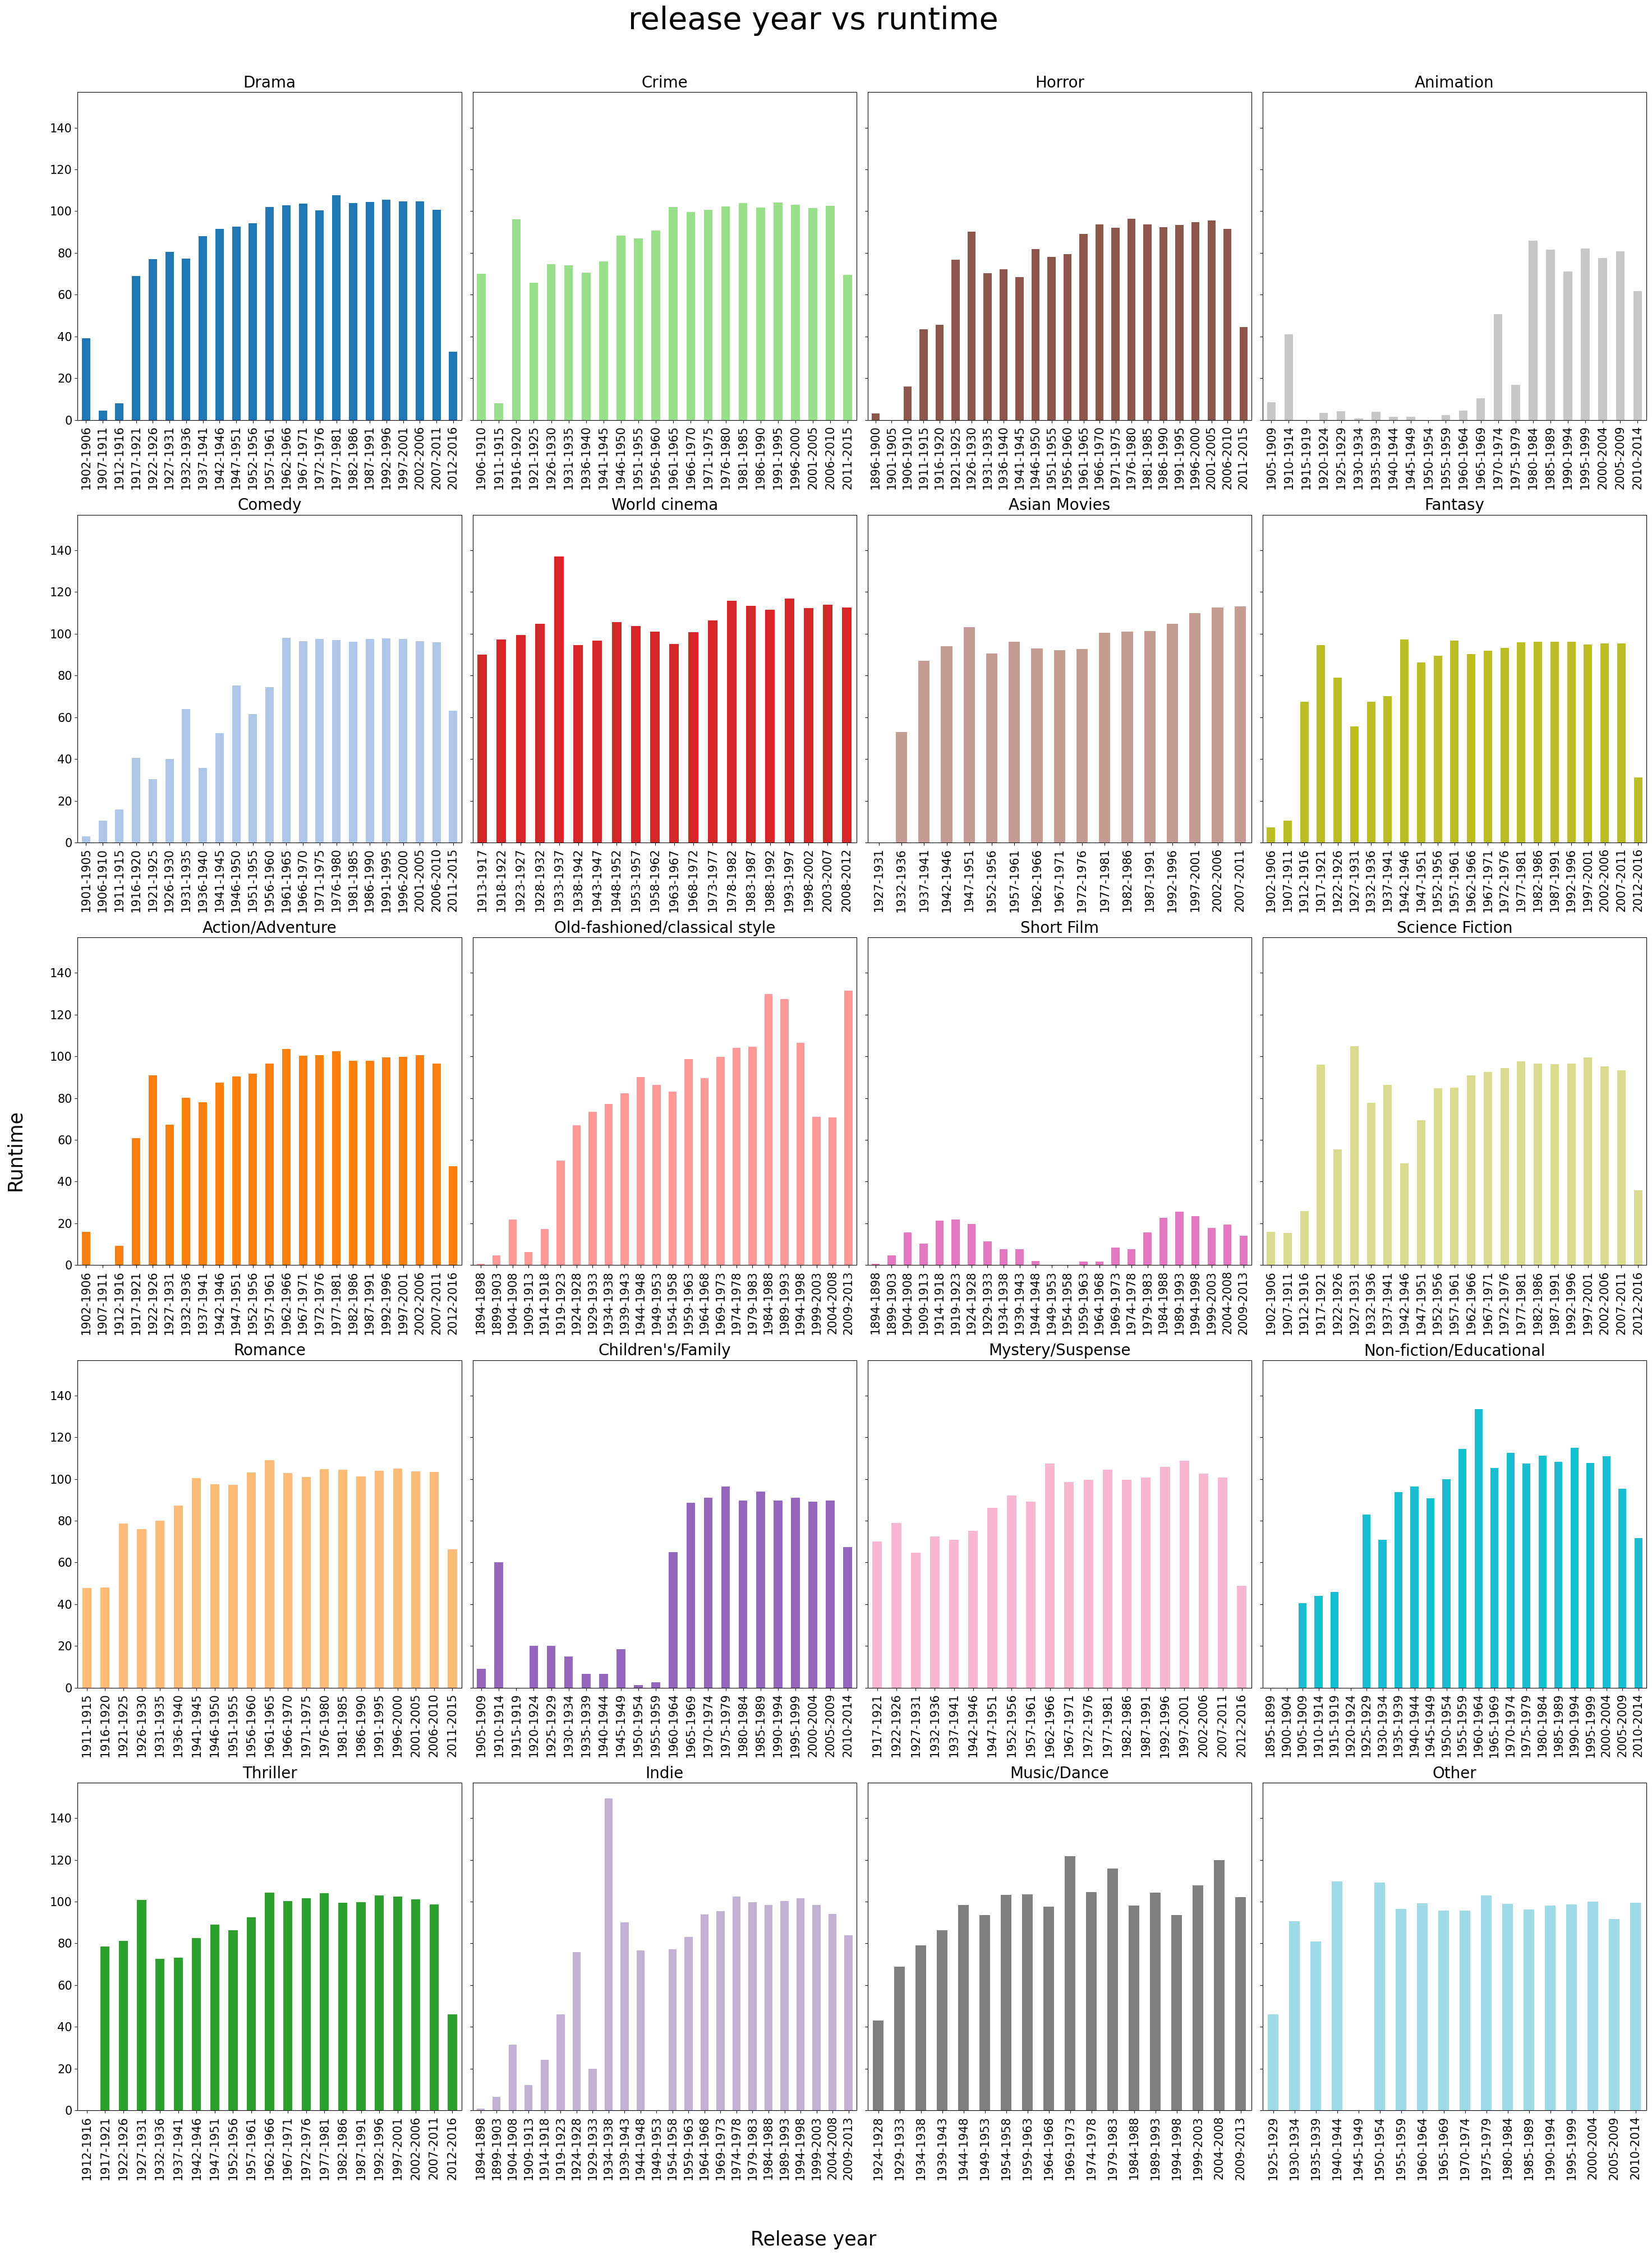

In [24]:
unique_genre = list()
MOVIES["new_genres"].apply(lambda x: unique_genre.extend(x))
unique_genre = Counter(unique_genre)
print(len(unique_genre))
unique_genre = {k: v for k, v in sorted(unique_genre.items(), key=lambda item: item[1], reverse=True)}
unique_genre = {k: unique_genre[k] for k in list(unique_genre)[:20]}
#unique_genre = {x:unique_genre[x] for x in unique_genre if unique_genre[x] >= 300}


fig, axes = plt.subplots(5, 4, figsize=(30, 40), sharey = True)
#fig.delaxes(axes[4, 3])
colors = sns.color_palette("tab20", len(unique_genre))
color_iter = iter(colors)

for j, genre in enumerate(unique_genre):

    df_filtered = MOVIES[MOVIES["new_genres"].apply(lambda x: genre in x)]
    bin_size = 5
    movies_year_runtime = df_filtered.groupby("release_year")["runtime"].median()
    binned_counts = {}
    for i in range(movies_year_runtime.index.min(), movies_year_runtime.index.max(), bin_size):
        bin_start, bin_end = i, i + bin_size - 1
        
        # Sum all the runtimes counts in this range.
        total_in_bin = movies_year_runtime[(movies_year_runtime.index >= bin_start) & (movies_year_runtime.index <= bin_end)].mean()
        
        binned_counts[f'{bin_start}-{bin_end}'] = total_in_bin


    binned_token_counts = pd.Series(binned_counts)
    color = next(color_iter)
    ax = axes[j%5, j//5]
    binned_token_counts.plot(kind='bar', ax=ax, color=color, fontsize=15)

    ax.set_title(genre, size = 20)
fig.supxlabel('Release year', size = 25)
fig.supylabel('Runtime', size = 25)
fig.suptitle('release year vs runtime', size = 40, y=1.01)
fig.tight_layout(rect=(0.025,0.025,1,1))

Text(0.5, 1.0, 'Genre vs runtime')

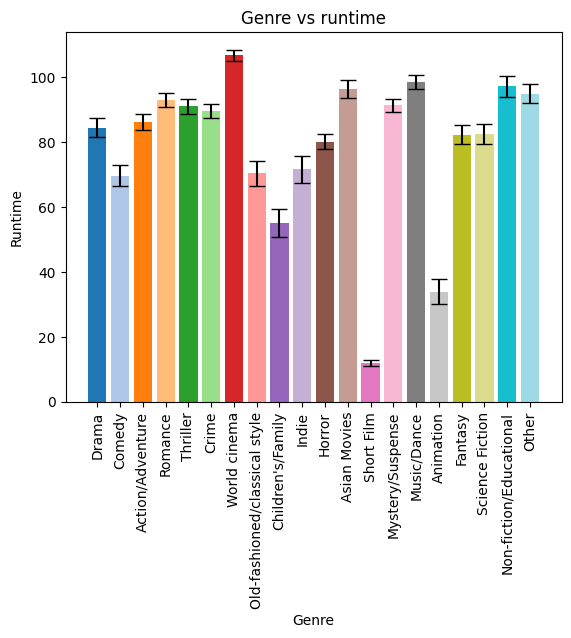

In [25]:
fig, ax = plt.subplots()
colors = sns.color_palette("tab20", len(unique_genre))
color_iter = iter(colors)
average = []
std = []
number_of_year_to_average = 5

for idx, genre in enumerate(unique_genre):

    df_filtered = MOVIES[MOVIES["new_genres"].apply(lambda x: genre in x)]
    medians = df_filtered.groupby("release_year")["runtime"].median()
    average.append(medians.mean())
    std.append(medians.std()/np.sqrt(medians.size))
    
ax.tick_params(axis='x', labelrotation=90)
for i in range(len(unique_genre)):
    color = next(color_iter)
    ax.bar(list(unique_genre.keys())[i], average[i], color=color)
    ax.errorbar(list(unique_genre.keys())[i], average[i], yerr=std[i],capsize=6,  color = 'k')
ax.set_xlabel("Genre")
ax.set_ylabel("Runtime")
ax.set_title("Genre vs runtime")

### Genre revenue analysis

Text(0.5, 1.0, 'Genre vs revenue')

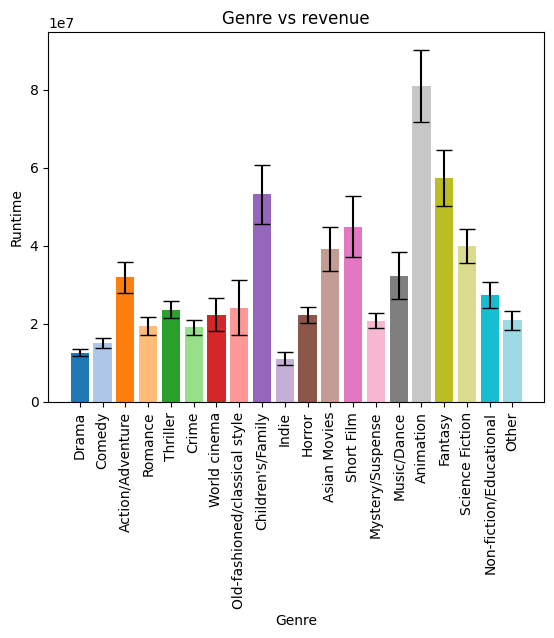

In [26]:
fig, ax = plt.subplots()
colors = sns.color_palette("tab20", len(unique_genre))
color_iter = iter(colors)
average = []
std = []
number_of_year_to_average = 5

for idx, genre in enumerate(unique_genre):

    df_filtered = MOVIES[MOVIES["new_genres"].apply(lambda x: genre in x)]
    df_filtered['revenue'].fillna(df_filtered['revenue'].median())
    group =  df_filtered.groupby("release_year")["revenue"].median()
    average.append(group.mean())
    std.append(group.std()/np.sqrt(group.size))
    
ax.tick_params(axis='x', labelrotation=90)
for i in range(len(unique_genre)):
    color = next(color_iter)
    ax.bar(list(unique_genre.keys())[i], average[i], color=color)
    ax.errorbar(list(unique_genre.keys())[i], average[i], yerr=std[i],capsize=6,  color = 'k')

ax.set_xlabel("Genre")
ax.set_ylabel("Runtime")
ax.set_title("Genre vs revenue")

### SCATTER PLOT YEAR VS BUDGET :D

39


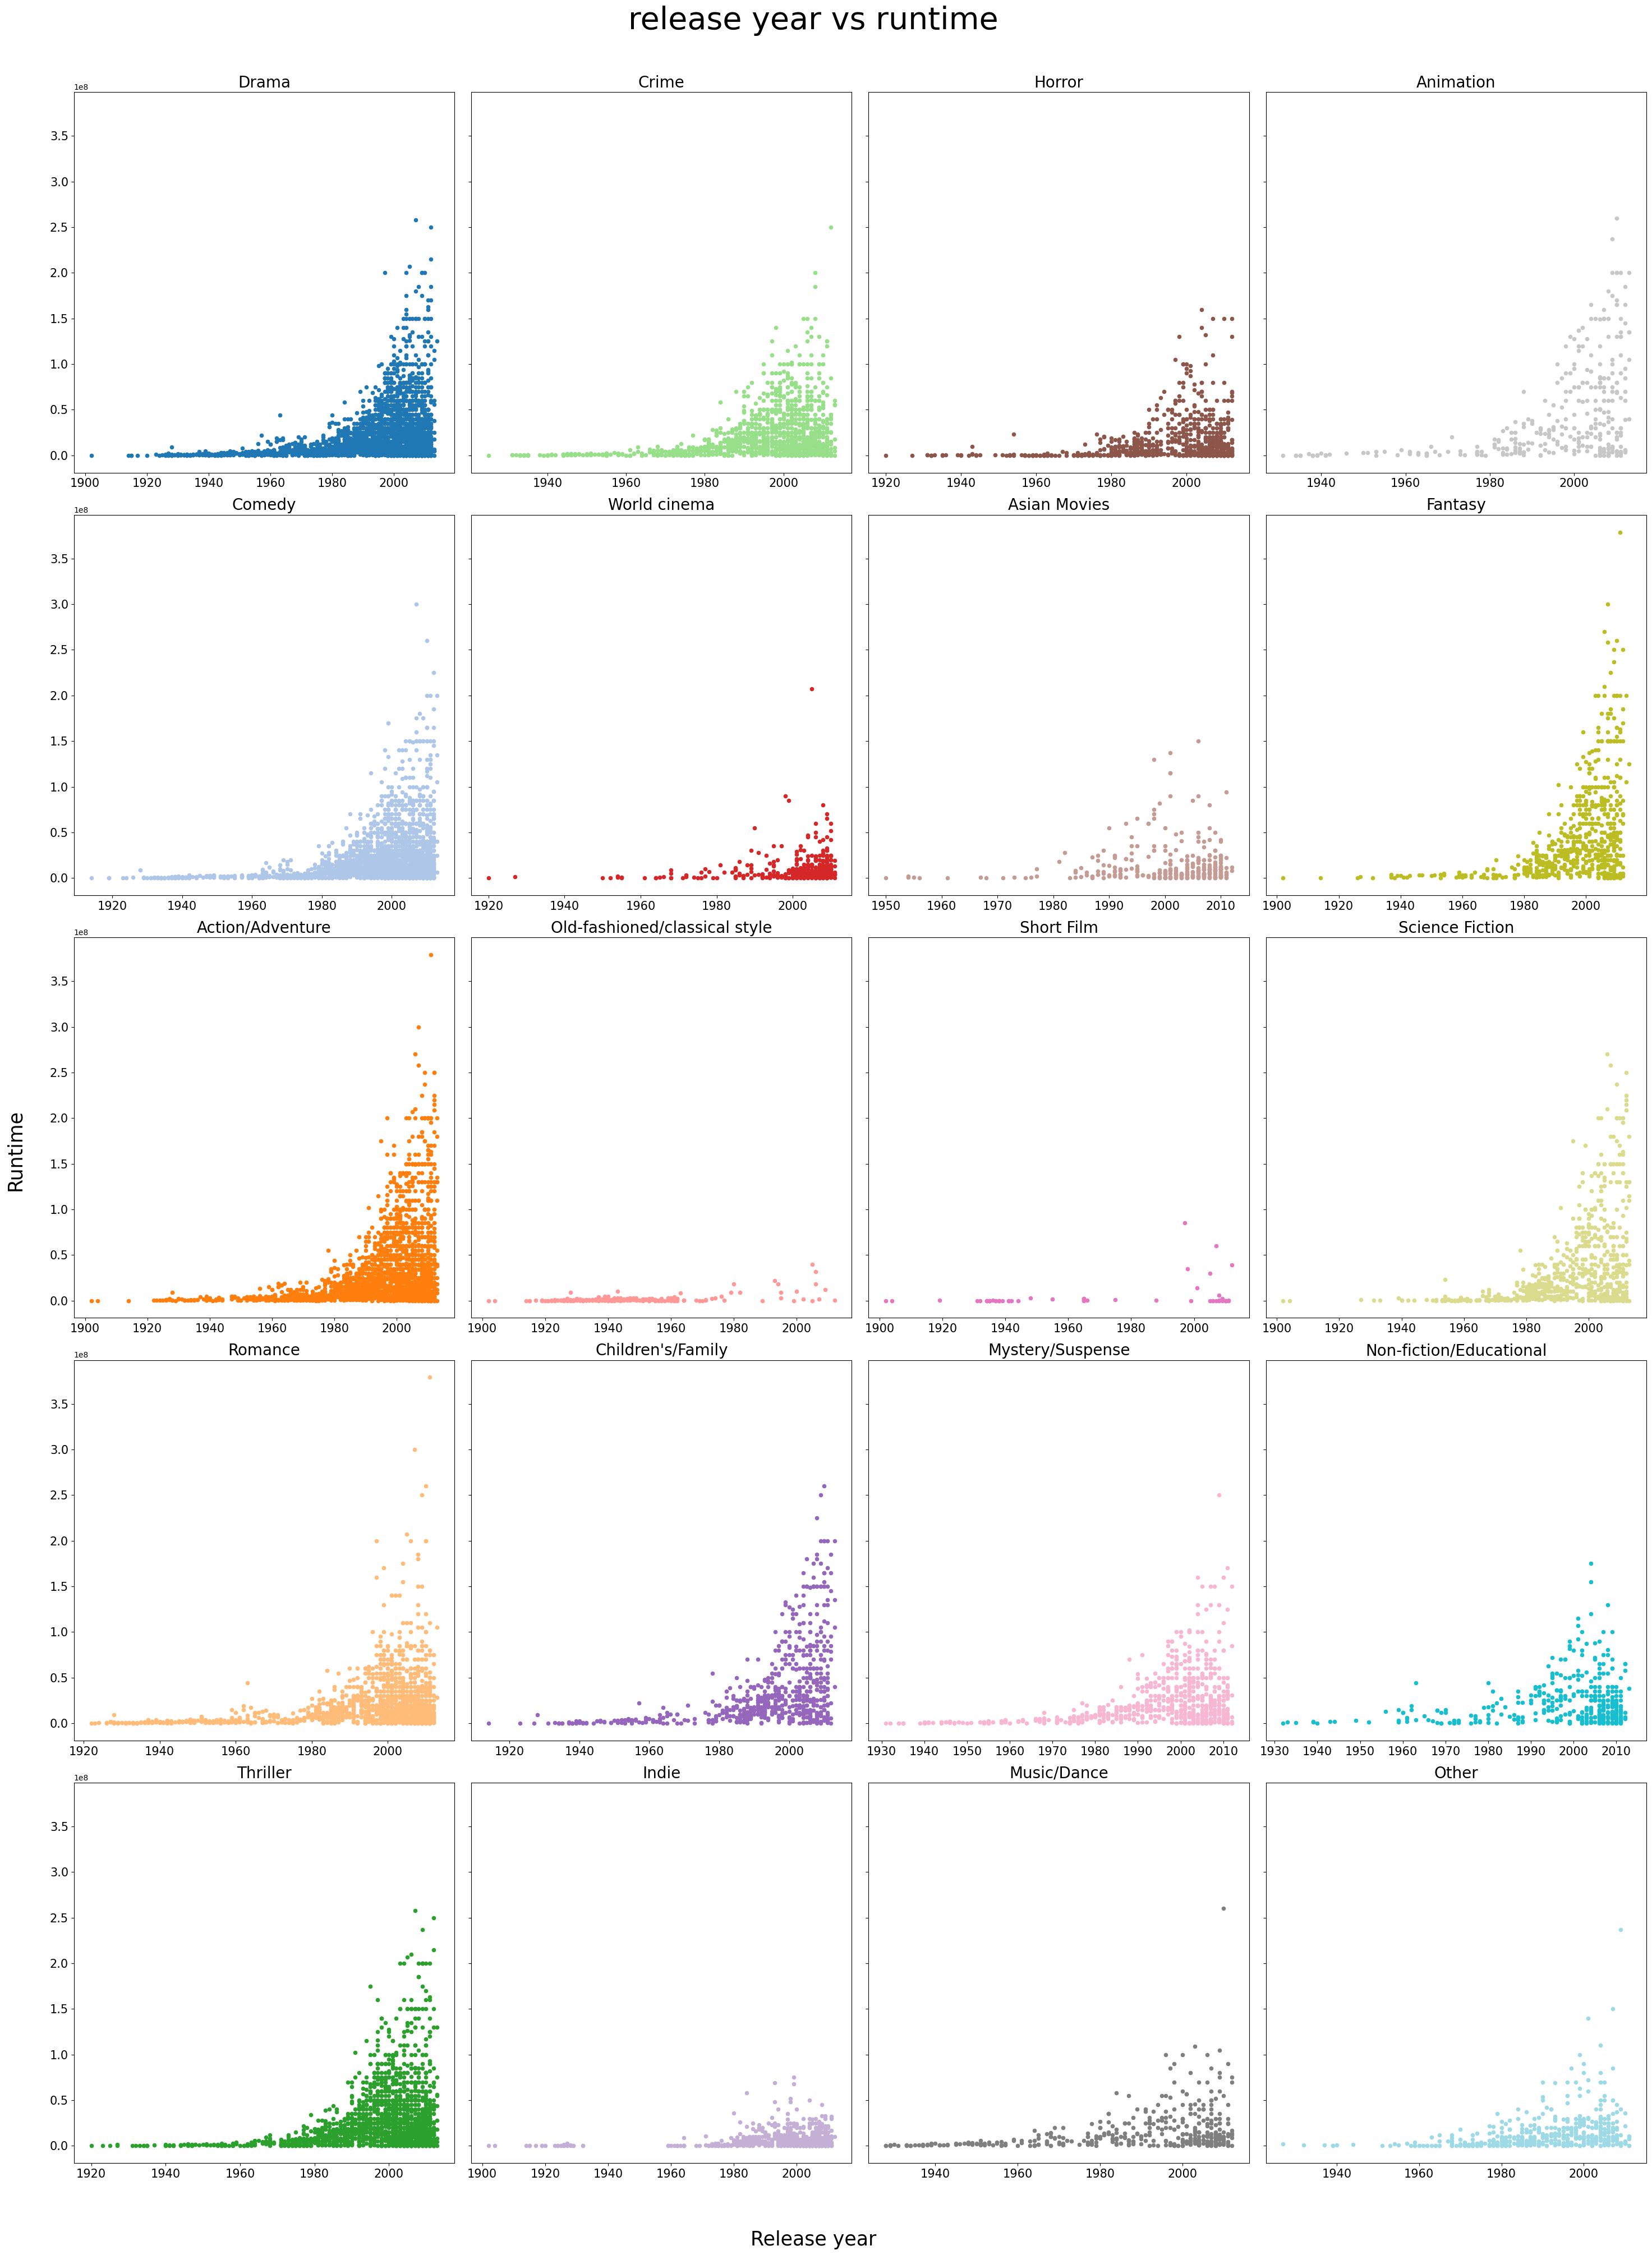

In [29]:
pd.options.mode.chained_assignment = None  # default='warn'

unique_genre = list()
MOVIES["new_genres"].apply(lambda x: unique_genre.extend(x))
unique_genre = Counter(unique_genre)
print(len(unique_genre))
unique_genre = {k: v for k, v in sorted(unique_genre.items(), key=lambda item: item[1], reverse=True)}
unique_genre = {k: unique_genre[k] for k in list(unique_genre)[:20]}
#unique_genre = {x:unique_genre[x] for x in unique_genre if unique_genre[x] >= 300}


fig, axes = plt.subplots(5, 4, figsize=(30, 40), sharey = True)
#fig.delaxes(axes[4, 3])
colors = sns.color_palette("tab20", len(unique_genre))
color_iter = iter(colors)

for j, genre in enumerate(unique_genre):

    df_filtered = MOVIES[MOVIES["new_genres"].apply(lambda x: genre in x)]
    df_filtered.dropna(subset=["budget"], inplace=True)
    df_filtered['budget'] = df_filtered['budget'].astype(int)
    df_filtered = df_filtered[df_filtered['budget'] != 0]
    color = next(color_iter)
    ax = axes[j%5, j//5]
    df_filtered.plot.scatter(x='release_year', y='budget', ax=ax, color=color, fontsize=15)
    ax.set_xlabel("")
    ax.set_ylabel("")

    ax.set_title(genre, size = 20)
fig.supxlabel('Release year', size = 25)
fig.supylabel('Runtime', size = 25)
fig.suptitle('release year vs runtime', size = 40, y=1.01)
fig.tight_layout(rect=(0.025,0.025,1,1))

### HEATMAP (╯°□°)╯︵ ┻━┻

39


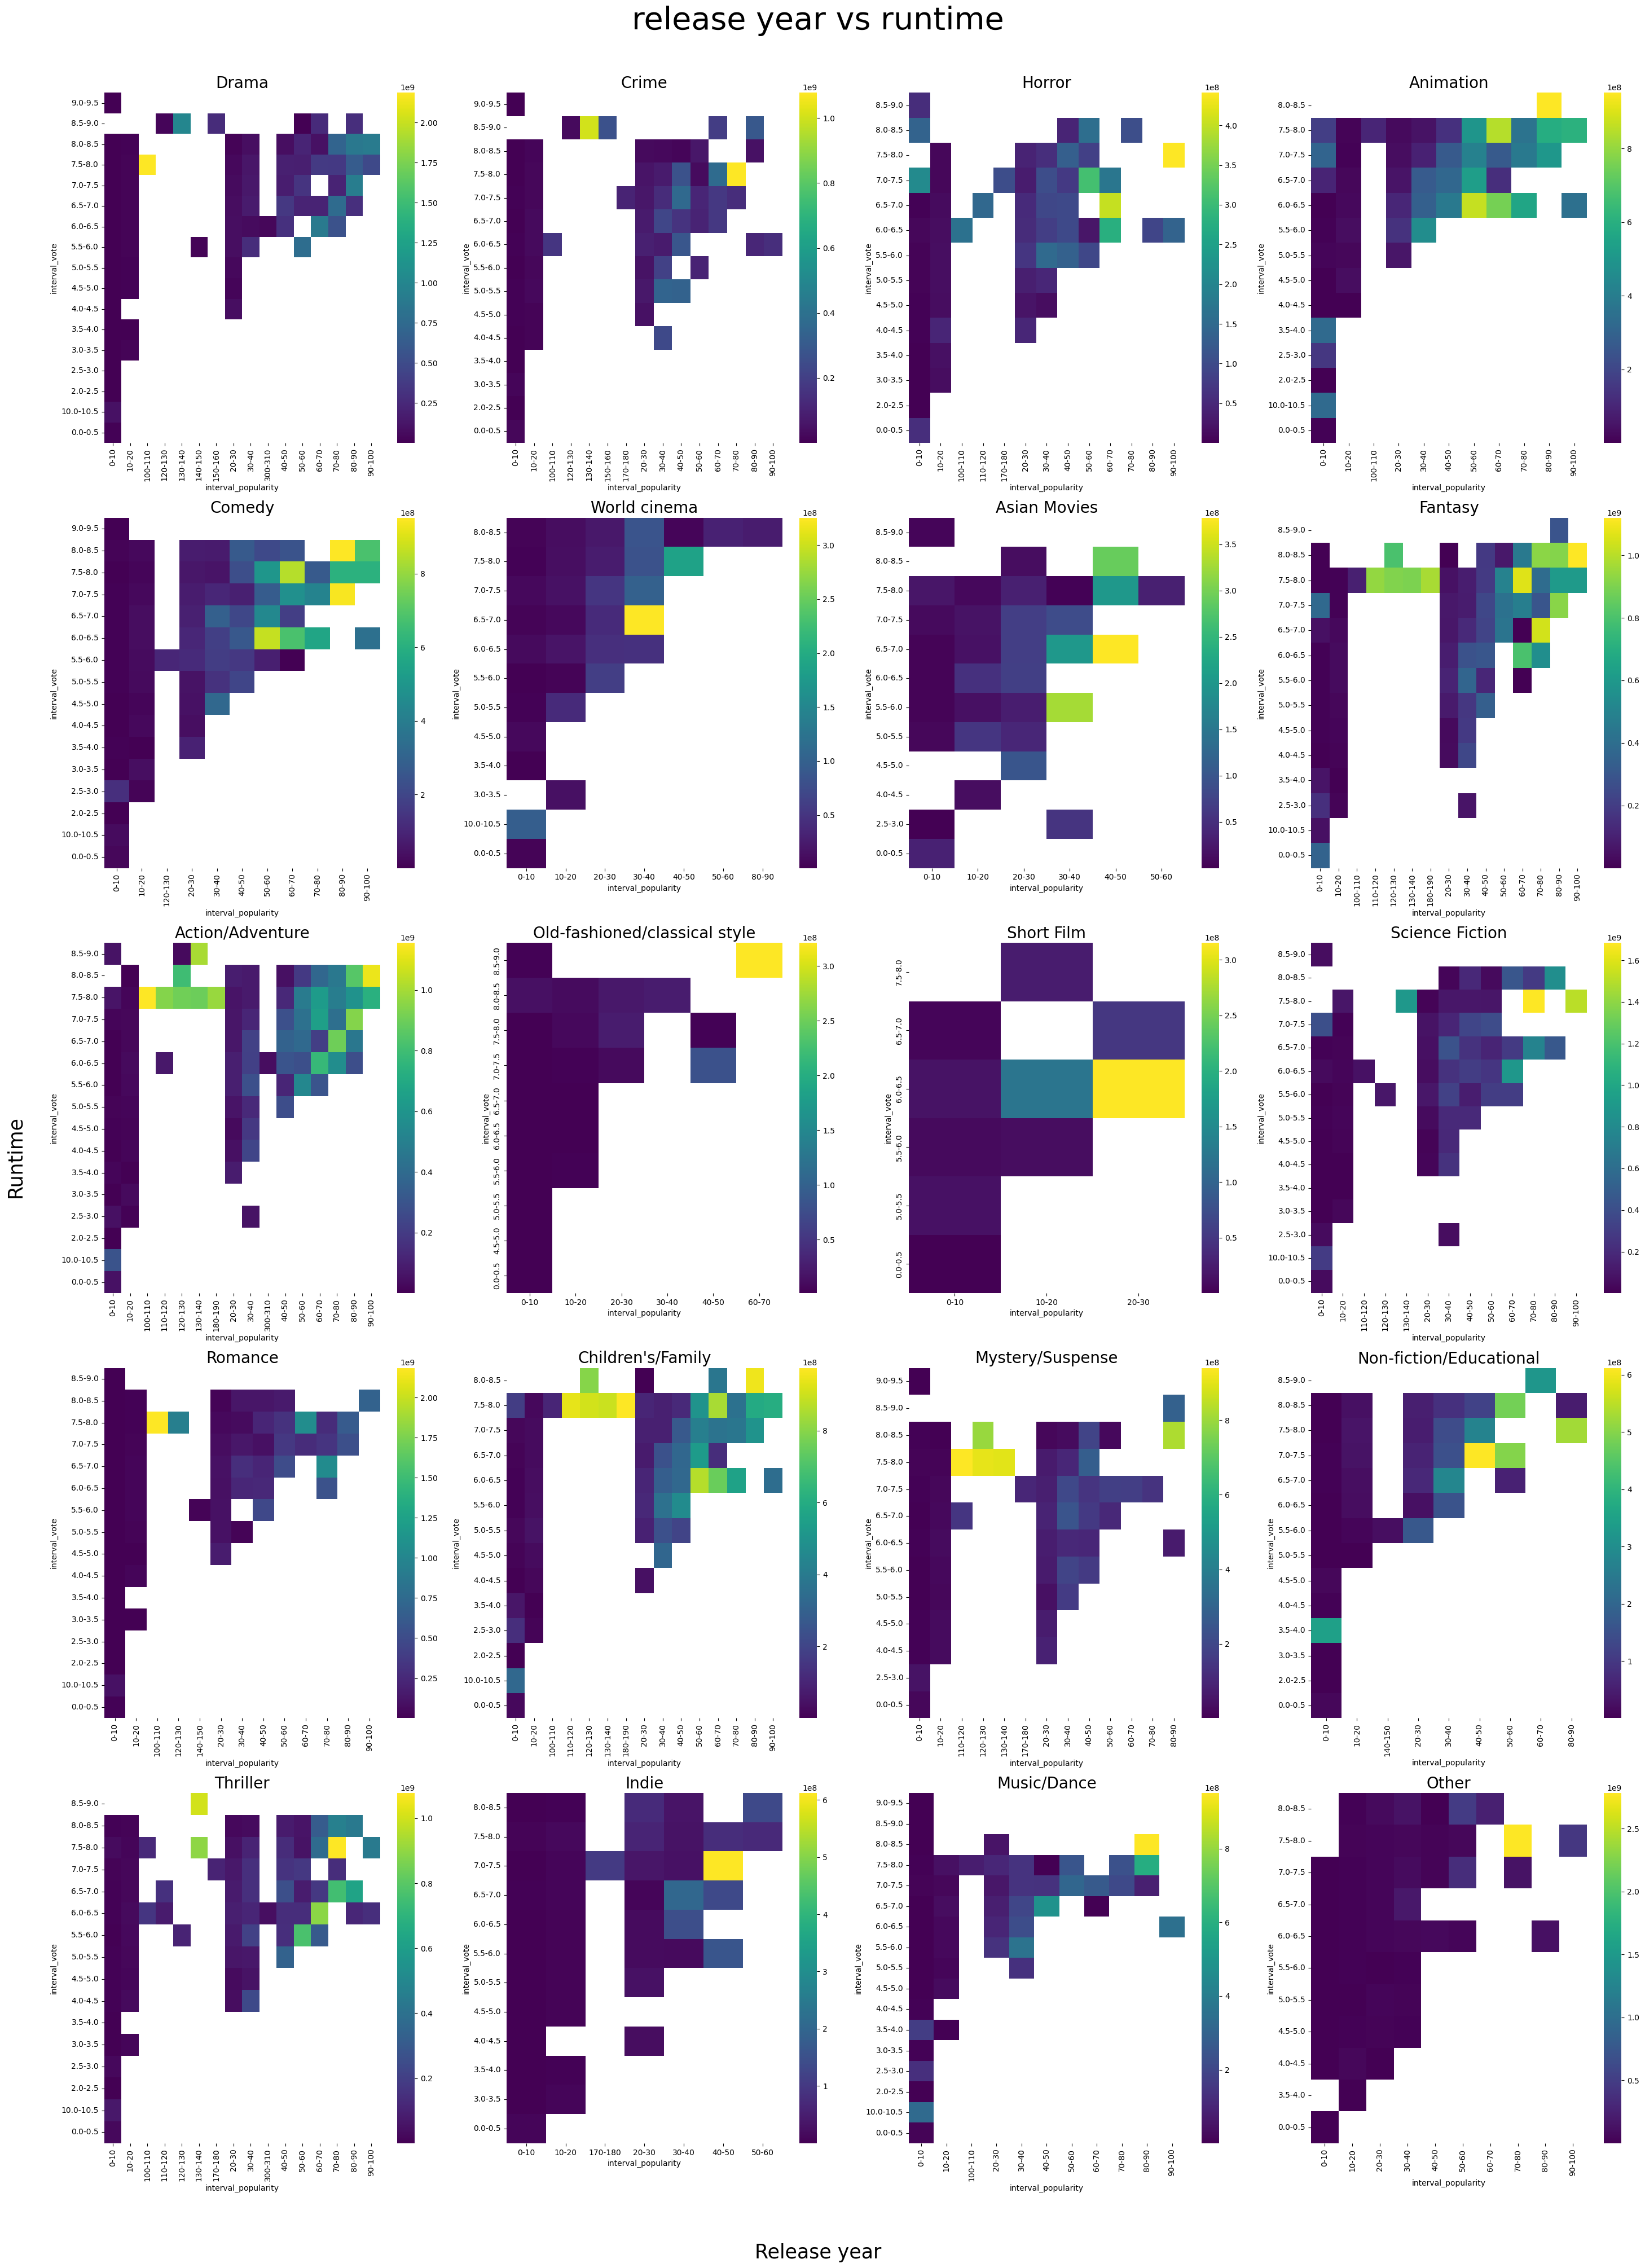

In [60]:
pd.options.mode.chained_assignment = None  # default='warn'

unique_genre = list()
MOVIES["new_genres"].apply(lambda x: unique_genre.extend(x))
unique_genre = Counter(unique_genre)
print(len(unique_genre))
unique_genre = {k: v for k, v in sorted(unique_genre.items(), key=lambda item: item[1], reverse=True)}
unique_genre = {k: unique_genre[k] for k in list(unique_genre)[:20]}
#unique_genre = {x:unique_genre[x] for x in unique_genre if unique_genre[x] >= 300}


fig, axes = plt.subplots(5, 4, figsize=(30, 40))
#fig.delaxes(axes[4, 3])
colors = sns.color_palette("tab20", len(unique_genre))
color_iter = iter(colors)

for j, genre in enumerate(unique_genre):
    

    df_filtered = MOVIES[MOVIES["new_genres"].apply(lambda x: genre in x)]
    df_filtered.dropna(subset=["vote_average", "popularity"], inplace=True)
    df_filtered['interval_vote'] = df_filtered['vote_average'].astype(float).apply(lambda x: f'{int(x/0.5)*0.5}-{int(x/0.5+1)*0.5}')
    df_filtered['interval_popularity'] = df_filtered['popularity'].astype(float).apply(lambda x: f'{int(x/10)*10}-{int(x/10+1)*10}')
    df_temp = pd.crosstab(df_filtered['interval_vote'], df_filtered['interval_popularity'], values = df_filtered['revenue'],
                  margins=False, aggfunc='median')

    color = next(color_iter)
    ax = axes[j%5, j//5]
    sns.heatmap(df_temp, annot=False, ax=ax, cmap='viridis')
    ax.invert_yaxis()
    ax.set_title(genre, size = 20)
fig.supxlabel('Release year', size = 25)
fig.supylabel('Runtime', size = 25)
fig.suptitle('release year vs runtime', size = 40, y=1.01)
fig.tight_layout(rect=(0.025,0.025,1,1))

# Character managment

In [ ]:
vgh

# MOVIE GENRE PREDICTOR MODEL

In [ ]:
import random
import torch

### Data spliting and cross validation definition

In [ ]:
def cross_validation_balanced_split(data, training_columns, testing_column, set_to_test, train_proportion = 0.2, seed = 42):
    divisions = int(1 / train_proportion)
    if set_to_test is None or set_to_test > divisions or set_to_test < 0:
        print("BE CAREFUL, ONLY VALUES FORM 0 to 1. Setting testing set to 0")
        set_to_test = 0
    # GET THE MOST FROM THE UNBALANCED CLASS
    train_proportion = train_proportion # 1/train_proportion divisioins, as default 2
    n = np.round(train_proportion, 0).astype(int)
        
    data_suffled = data.sample(frac=1, random_state=seed).reset_index(drop=True)

    training_set =  data_suffled[:n*set_to_test] + data_suffled[n*(set_to_test+1):] 
    testing_set = data_suffled[n*set_to_test:n*(set_to_test+1)]

    return (
        training_set[training_columns], 
        training_set[testing_column], 
        testing_set[training_columns], 
        testing_set[testing_column], 
    )

In [ ]:
training_columns = []
testing_column = []

training_set, training_target_set, testing_set, testing_target_set = cross_validation_balanced_split(MOVIES, 
                                                                                                     training_columns,
                                                                                                     testing_column,
                                                                                                     set_to_test = SETTINGS["MODEL_SETTINGS"]["TEST_SET"], 
                                                                                                     train_proportion =  SETTINGS["MODEL_SETTINGS"]["TEST_PROPORTION"],
                                                                                                     seed = SETTINGS["MODEL_SETTINGS"]["SEED"],
                                                                                                     )

### Model definition

In [ ]:
get_model = lambda feature_size, genre_size, layer_size: torch.nn.Sequential(
    # Input layer
    torch.nn.Linear(feature_size, layer_size),
    torch.nn.ReLU(),
    
    # Hidden layers
    torch.nn.Linear(layer_size, layer_size),
    torch.nn.ReLU(),
    torch.nn.Linear(layer_size, layer_size),
    torch.nn.ReLU(),
    torch.nn.Linear(layer_size, layer_size),
    torch.nn.ReLU(),
    
    # Output layer
    torch.nn.Linear(layer_size, genre_size),
    torch.nn.Sigmoid() # To get probabilities
)

### Model instance

In [ ]:
feature_size = 30 #len(training_columns)
genre_size = 30 #len(movie_genre)

model_factory = lambda: get_model(feature_size, genre_size, SETTINGS["MODEL_SETTINGS"]["LAYER_SIZE"])
model = model_factory()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device=device)

optimizer_kwargs = dict(
    lr=3e-4,
    weight_decay=1e-3,
)
optimizer = torch.optim.AdamW(model.parameters(), **optimizer_kwargs)

### Model training

In [ ]:
def train_model(batches_train, batches_test, model, optimizer, classification_threshold, device):
    # Set model to training mode 
    model.train()

    loss_history = []
    accuracy_history = []
    f_score_history = []
    precision_history = []
    recall_history = []
    # Change the loop to get batch_idx, data and target from train_loader
    for sample_i, (data, target) in enumerate(zip(batches_train, batches_test)):
        N = data.shape[0] 
        Dy = target.shape[1] # Number of possible genre 
        
        # Move the data to the device
        data = data.to(device)
        target = target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        
        loss = torch.nn.BCELoss()(output, target)
        loss_float = loss.item()
        # Backpropagate loss & Perform an optimizer step
        loss.backward()
        optimizer.step()
        
        
        # Compute accuracy and loss of the batch
        output_hot, correct = get_output_hot(output, target, classification_threshold)
        accuracy = correct.item() / (N * Dy) 
        f_score, precision, recall = compute_avg_f_score(output_hot, target)
        
        accuracy_history.append(accuracy)
        loss_history.append(loss_float)
        f_score_history.append(f_score)
        precision_history.append(precision)
        recall_history.append(recall)
        
        if sample_i % (1000 // N) == 0: # Every 1000 samples
            print(f'Batch {loss_float = :.3f}')
            print(f'Batch {accuracy = :.3f}')
            print(f'Batch {f_score = :.3f}')
            print(f'Batch {precision = :.3f}')
            print(f'Batch {recall = :.3f}')
    # print(f"{loss_history = }, {accuracy_history = }")
    return model, loss_history, accuracy_history

def get_output_hot(output, target, classification_threshold):
    output_hot = (output > classification_threshold).int() # we have |N| x |genre| matrix
    correct = torch.sum(output_hot == target)

    return output_hot, correct

def compute_avg_f_score(output_hot, target):
    true_positives = torch.sum((output_hot & target), dim = 1)
    false_positives = torch.sum((output_hot & ~target), dim = 1)
    false_negatives = torch.sum((~output_hot & target), dim = 1)
    
    denominator = true_positives + false_positives
    precision = torch.where(denominator > 0,
                            true_positives / denominator,
                            torch.zeros_like(true_positives)
                            )
    
    denominator = true_positives + false_negatives
    recall = torch.where(denominator > 0,
                         true_positives / denominator,
                         torch.zeros_like(true_positives)
                         )
    
    denominator = precision + recall
    f_score = torch.where(denominator > 0,
                          2*(precision * recall) / denominator,
                          torch.zeros_like(true_positives)
                          )
                          
    return torch.mean(f_score), torch.mean(precision), torch.mean(recall)

We use stochastic training for better performance. The batch size is 10 by default.

In [ ]:
def get_training_batch(training_set, target_set, batch_size = 10):
    assert len(training_set) == len(target_set), "Lists must be of equal length."
    
    batches_train = []
    batches_test = []
    for i in range(0, len(training_set), batch_size):
        # batches_train.append(training_set[i:i+batch_size])
        # batches_test.append(target_set[i:i+batch_size])
        batches_train.append(torch.tensor(training_set[i:i+batch_size]))
        batches_test.append(torch.tensor(target_set[i:i+batch_size]))
        
    return batches_train, batches_test

In [ ]:
batches_train, batches_test = get_training_batch(training_set, training_target_set)

trained_model, train_loss, train_acc = train_model(
    batches_train, batches_test, model, optimizer, SETTINGS["MODEL_SETTINGS"]["GENRE_THRESHOLD"], device
) 

### Training Plotting

In [ ]:
batch_indices = [i for i in range(len(batches_train))]

plt.figure(figsize=(6.4, 4.8))
plt.subplot(1, 2, 1)
plt.plot(batch_indices, trained_model)
plt.xlabel("Batch")
plt.ylabel("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(batch_indices, train_loss)
plt.xlabel("Batch")
plt.ylabel("Loss")

### Model testing

In [ ]:
def test_model(model, testing_set, testing_target_set, classification_threshold):
    N = testing_set.shape[0] 
    Dy = testing_target_set.shape[1] 
    
    with torch.no_grad():
        output = model(testing_set)
        
    output_hot, correct = get_output_hot(output, testing_target_set, classification_threshold)
    
    accuracy = correct.item() / (N * Dy) 
    
    print(f'Testing accuracy = {accuracy:0.3f}')
    
    return output_hot
    

In [ ]:
testing_set = torch.tensor(testing_set).to(device)
testing_target_set = torch.tensor(testing_target_set).to(device)

predictions = test_model(trained_model, testing_set, testing_target_set, SETTINGS["MODEL_SETTINGS"]["GENRE_THRESHOLD"])

genre_labels = ["Action", "Drama", "Comedy", "Sci-Fi", "Horror", "Romance", "Documentary", "Fantasy", "Thriller", "Animation"]
predicted_genre = []

for movie_prediction in predictions:
    genres = [genre_labels[i] for i, is_genre in enumerate(movie_prediction) if is_genre == 1]
    predicted_genre.append(genres)

predictins_output = pd.DataFrame({
    'wikipedia_movie_ID': testing_set["wikipedia_movie_ID"],
    'name': testing_set["name"],
    'predicted_genres': predicted_genre,
})


predictins_output.to_csv("movies_predicted_genre.csv", index = False)


# TRASH CODE TESTING

In [ ]:
training_set = [i for i in range(1, 105)]
training_target_set = [i**2 for i in range(1, 105)]


batches_train, batches_test = get_training_batch(training_set, training_target_set)

print(batches_train, batches_test)

for sample_i, (data, target) in enumerate(zip(batches_train, batches_test)):
     print(f"\n\n{sample_i = }")
     print(f"{data = }")
     print(f"{target = }")

[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], [11, 12, 13, 14, 15, 16, 17, 18, 19, 20], [21, 22, 23, 24, 25, 26, 27, 28, 29, 30], [31, 32, 33, 34, 35, 36, 37, 38, 39, 40], [41, 42, 43, 44, 45, 46, 47, 48, 49, 50], [51, 52, 53, 54, 55, 56, 57, 58, 59, 60], [61, 62, 63, 64, 65, 66, 67, 68, 69, 70], [71, 72, 73, 74, 75, 76, 77, 78, 79, 80], [81, 82, 83, 84, 85, 86, 87, 88, 89, 90], [91, 92, 93, 94, 95, 96, 97, 98, 99, 100], [101, 102, 103, 104]] [[1, 4, 9, 16, 25, 36, 49, 64, 81, 100], [121, 144, 169, 196, 225, 256, 289, 324, 361, 400], [441, 484, 529, 576, 625, 676, 729, 784, 841, 900], [961, 1024, 1089, 1156, 1225, 1296, 1369, 1444, 1521, 1600], [1681, 1764, 1849, 1936, 2025, 2116, 2209, 2304, 2401, 2500], [2601, 2704, 2809, 2916, 3025, 3136, 3249, 3364, 3481, 3600], [3721, 3844, 3969, 4096, 4225, 4356, 4489, 4624, 4761, 4900], [5041, 5184, 5329, 5476, 5625, 5776, 5929, 6084, 6241, 6400], [6561, 6724, 6889, 7056, 7225, 7396, 7569, 7744, 7921, 8100], [8281, 8464, 8649, 8836, 9025, 9216, 9409, 9604, 

In [ ]:
hot =  torch.tensor([[0,0,0,0,0,0,0,0,0,1], [0,0,0,0,0,0,0,0,1,1], [0,0,0,0,0,1,0,0,0,1], [0,0,0,0,0,0,1,0,0,1], [0,0,0,0,0,1,0,0,0,1]])
targ = torch.tensor([[0,0,0,0,0,0,0,0,0,1], [0,0,0,0,0,0,0,0,0,1], [0,0,0,0,0,1,1,0,0,1], [0,0,0,0,0,1,0,0,0,1], [0,0,0,0,0,1,0,1,1,1]])

f_score, precision, recall = compute_avg_f_score(hot, targ)
print(f'{f_score = :.3f}, {precision = :.3f}, {recall = :.3f},')

f_score = 0.727, precision = 0.800, recall = 0.733,
